# Quick start
https://prospect.readthedocs.io/en/latest/quickstart.html

https://astrodatascience.net/introduction-to-sdss/

Here’s a quick intro that fits 5-band SDSS photometry with a simple delay-tau parametric SFH model. This assumes you’ve successully installed prospector and all the prerequisites. This is intended simply to introduce the key ingrediants; for more realistic usage see Demonstrations or the Tutorial.

In [1]:
import fsps
import dynesty
import sedpy
import h5py, astropy
import numpy as np
import astroquery
import matplotlib.pyplot as plt

# Build an observation
First we’ll get some data, using astroquery to get SDSS photometry of a galaxy. We’ll also get spectral data so we know the redshift.

https://notebook.community/astro4dev/OAD-Data-Science-Toolkit/Teaching%20Materials/Programming/Python/PythonISYA2018/04.Astropy/04_query

In [2]:
from astroquery.sdss import SDSS
from astropy.coordinates import SkyCoord
bands = "ugriz"
mcol = [f"cModelMag_{b}" for b in bands]
ecol = [f"cModelMagErr_{b}" for b in bands]
cat = SDSS.query_crossid(SkyCoord(ra=204.46376, dec=35.79883, unit="deg"),
                         data_release=16,
                         photoobj_fields=mcol + ecol + ["specObjID"])
shdus = SDSS.get_spectra(plate=2101, mjd=53858, fiberID=220)[0]
assert int(shdus[2].data["SpecObjID"][0]) == cat[0]["specObjID"]

/Users/dagoret/anaconda3/envs/prospector/lib/python3.8/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


In [3]:
cat

obj_id,objID,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z,cModelMagErr_u,cModelMagErr_g,cModelMagErr_r,cModelMagErr_i,cModelMagErr_z,specObjID,obj_id1,type
bytes5,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,bytes6
obj_0,1237664853103214719,18.84532,17.10918,16.42916,16.07117,15.88824,0.01943965,0.00431355,0.003938866,0.003961648,0.006623326,2365576242142406656,1237664853103214719,GALAXY


In [4]:
spectra_data = shdus[1].data

In [5]:
galaxyname = shdus[2].data["SpecObjID"][0]
galaxyname

'   2365576242142406656'

In [6]:
redshift = shdus[2].data[0]["z"]
redshift

0.07260209

In [7]:
lines = shdus[3].data
lines['LINENAME']

chararray(['Ly_alpha', 'N_V 1240', 'C_IV 1549', 'He_II 1640',
           'C_III] 1908', 'Mg_II 2799', '[O_II] 3725', '[O_II] 3727',
           '[Ne_III] 3868', 'H_epsilon', '[Ne_III] 3970', 'H_delta',
           'H_gamma', '[O_III] 4363', 'He_II 4685', 'H_beta',
           '[O_III] 4959', '[O_III] 5007', 'He_II 5411', '[O_I] 5577',
           '[O_I] 6300', '[S_III] 6312', '[O_I] 6363', '[N_II] 6548',
           'H_alpha', '[N_II] 6583', '[S_II] 6716', '[S_II] 6730',
           '[Ar_III] 7135'], dtype='<U13')

In [8]:
for n in ['[O_II] 3727', '[O_III] 5007', 'H_alpha']:
    print(n, " ->", lines['LINEWAVE'][lines['LINENAME']==n])

[O_II] 3727  -> [3729.875448]
[O_III] 5007  -> [5008.23963773]
H_alpha  -> [6564.61389433]


Text(0.5, 1.0, 'SDSS spectrum of   2365576242142406656')

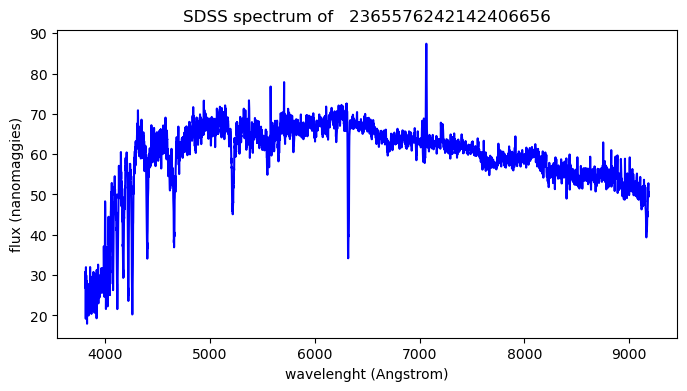

In [9]:
fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.plot(10**spectra_data['loglam'], spectra_data['flux'],'b-')
ax.set_xlabel('wavelenght (Angstrom)')
ax.set_ylabel('flux (nanomaggies)')
ax.set_title('SDSS spectrum of'+galaxyname)

Now we will put this data in a dictionary with format expected by prospector. We convert the magnitudes to maggies, convert the magnitude errors to flux uncertainties (including a noise floor), and load the filter transmission curves using sedpy. We’ll store the redshift here as well for convenience. Note that for this example we do not attempt to fit the spectrum at the same time.

In [10]:
from sedpy.observate import load_filters
from prospect.utils.obsutils import fix_obs

filters = load_filters([f"sdss_{b}0" for b in bands])
maggies = np.array([10**(-0.4 * cat[0][f"cModelMag_{b}"]) for b in bands])
magerr = np.array([cat[0][f"cModelMagErr_{b}"] for b in bands])
magerr = np.clip(magerr, 0.05, np.inf)

obs = dict(wavelength=None, spectrum=None, unc=None, redshift=shdus[2].data[0]["z"],
           maggies=maggies, maggies_unc=magerr * maggies / 1.086, filters=filters)
obs = fix_obs(obs)    

Text(0.5, 1.0, 'SDSS')

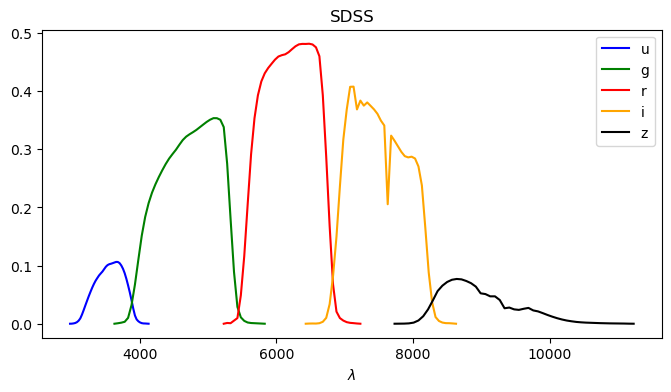

In [11]:
col = ["b","g","r","orange","k"]
fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
for idx, filt in enumerate(filters):
    #filt.display()
    ax.plot(filt.wavelength,filt.transmission,c=col[idx],label=bands[idx])
ax.set_xlabel("$\lambda$")
ax.legend()
ax.set_title("SDSS")

In [12]:
obs

{'wavelength': None,
 'spectrum': None,
 'unc': None,
 'redshift': 0.07260209,
 'maggies': array([2.89648978e-08, 1.43326996e-07, 2.68124192e-07, 3.72848156e-07,
        4.41269591e-07]),
 'maggies_unc': array([1.33355883e-09, 6.59884882e-09, 1.23445760e-08, 1.71661214e-08,
        2.03162795e-08]),
 'filters': [<class 'sedpy.observate.Filter'>(sdss_u0),
  <class 'sedpy.observate.Filter'>(sdss_g0),
  <class 'sedpy.observate.Filter'>(sdss_r0),
  <class 'sedpy.observate.Filter'>(sdss_i0),
  <class 'sedpy.observate.Filter'>(sdss_z0)],
 'phot_mask': array([ True,  True,  True,  True,  True]),
 'filternames': ['sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'sdss_z0'],
 'logify_spectrum': False,
 'ndof': 5}

# Build a Model
Here we will get a default parameter set for a simple parametric SFH, and add a set of parameters describing nebular emission. We’ll also fix the redshift to the value given by SDSS. This model has 5 free parameters, each of which has a an associated prior distribution. These default prior distributions can and should be replaced or adjusted depending on your particular science question.

In [13]:
from prospect.models.templates import TemplateLibrary
from prospect.models import SpecModel
model_params = TemplateLibrary["parametric_sfh"]
model_params.update(TemplateLibrary["nebular"])
model_params["zred"]["init"] = obs["redshift"]

model = SpecModel(model_params)
assert len(model.free_params) == 5
print(model)

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.07260209] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [0] 
  add_neb_emission: [ True] 
  add_neb_continuum: [ True] 
  nebemlineinspec: [ True] 
  gas_logz: [0.] <function stellar_logzsol at 0x7fc5aaa725e0>
  gas_logu: [-2.] 


In principle we could also add noise models for the spectral and photometric data, but we’ll make the default assumption of independent Gaussian noise for the moment.

In [14]:
noise_model = (None, None)

# Get a ‘Source’
Now we need an object that will actually generate the galaxy spectrum using stellar population synthesis. For this we will use an object that wraps FSPS allowing access to all the parameterized SFHs. We will also just check which spectral and isochrone librariews are being used.

In [15]:
from prospect.sources import CSPSpecBasis
sps = CSPSpecBasis(zcontinuous=1)
print(sps.ssp.libraries)

(b'mist', b'miles', b'DL07  ')


# Make a prediction
We can now predict our data for any set of parameters. This will take a little time because fsps is building and caching the SSPs. Subsequent calls to predict will be faster. Here we’ll just make the predicition for the current value of the free parameters.

In [16]:
current_parameters = ",".join([f"{p}={v}" for p, v in zip(model.free_params, model.theta)])
print(current_parameters)
spec, phot, mfrac = model.predict(model.theta, obs=obs, sps=sps)
print(phot / obs["maggies"])

mass=10000000000.0,logzsol=-0.5,dust2=0.6,tage=1.0,tau=1.0
[6.20307375 2.56684774 1.36475995 1.3654112  1.02082463]


# Run a fit
Since we can make predictions and we have data and uncertainties, we should be able to construct a likelihood function. Here we’ll use the pre-defined default posterior probability function. We also set some sampling related keywords to make the fit go a little faster, though it should still take of order tens of minutes.

In [17]:
from prospect.fitting import lnprobfn, fit_model
fitting_kwargs = dict(nlive_init=400, nested_method="rwalk", nested_target_n_effective=1000, nested_dlogz_init=0.05)
output = fit_model(obs, model, sps, optimize=False, dynesty=True, lnprobfn=lnprobfn, noise=noise_model, **fitting_kwargs)
result, duration = output["sampling"]


iter: 1398 | batch: 0 | nc: 1 | ncall: 28128 | eff(%):  4.970 | logz: 77.978 +/-  0.284 | dlogz:  0.000 >  0.050        


done dynesty (initial) in 1912.8723080158234s


iter: 2211 | batch: 3 | nc: 1 | ncall: 35943 | eff(%):  5.362 | loglstar: 83.758 < 87.369 < 84.267 | logz: 78.000 +/-  0.250 | stop:  1.016      

done dynesty (dynamic) in 417.1724979877472s


The result is a dictionary with keys giving the Monte Carlo samples of parameter values and the corresponding posterior probabilities. Because we are using dynesty, we also get weights associated with each parameter sample in the chain.

Typically we’ll want to save the fit information. We can save the output of the sampling along with other information about the model and the data that was fit as follows:

In [18]:
from prospect.io import write_results as writer
hfile = "./quickstart_dynesty_mcmc.h5"
writer.write_hdf5(hfile, {}, model, obs,
                 output["sampling"][0], None,
                 sps=sps,
                 tsample=output["sampling"][1],
                 toptimize=0.0)

/Users/dagoret/anaconda3/envs/prospector/lib/python3.8/site-packages/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)
/Users/dagoret/anaconda3/envs/prospector/lib/python3.8/site-packages/prospect/io/write_results.py:290: RuntimeWarning: Could not JSON serialize model_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
/Users/dagoret/anaconda3/envs/prospector/lib/python3.8/site-packages/prospect/io/write_results.py:320: UserWarning: Could not JSON serialize redshift, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k))
/Users/dagoret/anaconda3/envs/prospector/lib/python3.8/site-packages/prospect/io/write_results.py:49: RuntimeWarning: Could not obtain prospector version info
  warnings.warn("Could not obtain prospector version info", RuntimeWarning)


In [27]:
model

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.07260209] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [0] 
  add_neb_emission: [ True] 
  add_neb_continuum: [ True] 
  nebemlineinspec: [ True] 
  gas_logz: [-1.08387129] <function stellar_logzsol at 0x7fc5aaa725e0>
  gas_logu: [-2.] 

# Make plots
Now we’ll want to read the saved fit information and make plots. To read the information we can use the built-in reader.

In [19]:
from prospect.io import read_results as reader
hfile = "./quickstart_dynesty_mcmc.h5"
out, out_obs, out_model = reader.results_from(hfile)

This gives a dictionary of useful information (out), as well as the obs dictionary that we were using and, in some cases, a reconsitituted model object. However, that is only possible if the model generation code is saved to the results file, in the form of the text for a build_model() function. Here we will use just use the model object that we’ve already generated.

Now we will do some plotting. First, lets make a corner plot of the posterior. We’ll mark the highest probablity posterior sample as well.

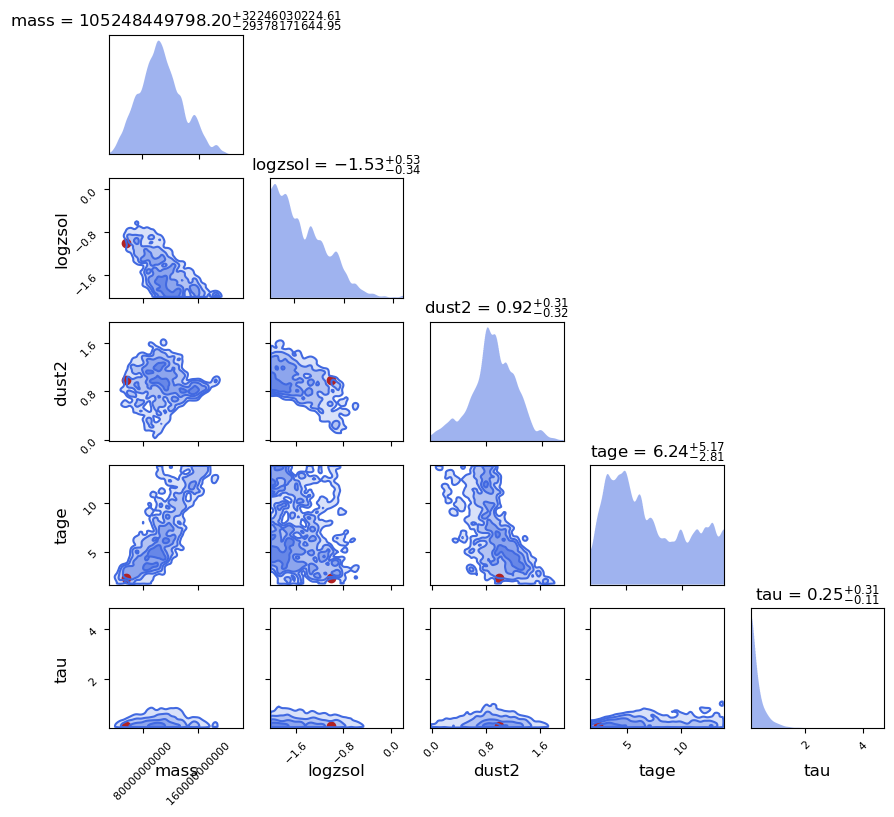

In [20]:
import matplotlib.pyplot as pl
from prospect.plotting import corner
nsamples, ndim = out["chain"].shape
cfig, axes = pl.subplots(ndim, ndim, figsize=(10,9))
axes = corner.allcorner(out["chain"].T, out["theta_labels"], axes, weights=out["weights"], color="royalblue", show_titles=True)

from prospect.plotting.utils import best_sample
pbest = best_sample(out)
corner.scatter(pbest[:, None], axes, color="firebrick", marker="o")

Note that the highest probability sample may well be different than the peak of the marginalized posterior distribution.

Now let’s plot the observed SED and the spectrum and SED of the highest probability posterior sample.

Text(0, 0.5, '$\\chi_{\\rm best}$')

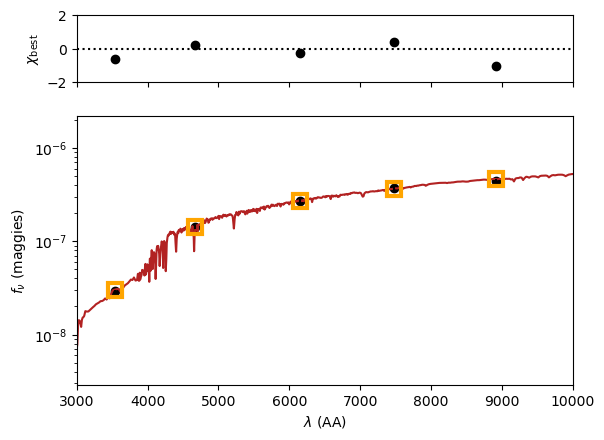

In [21]:
import matplotlib.pyplot as pl
sfig, saxes = pl.subplots(2, 1, gridspec_kw=dict(height_ratios=[1, 4]), sharex=True)
ax = saxes[1]
pwave = np.array([f.wave_effective for f in out_obs["filters"]])
# plot the data
ax.plot(pwave, out_obs["maggies"], linestyle="", marker="o", color="k")
ax.errorbar(pwave,  out_obs["maggies"], out_obs["maggies_unc"], linestyle="", color="k", zorder=10)
ax.set_ylabel(r"$f_\nu$ (maggies)")
ax.set_xlabel(r"$\lambda$ (AA)")
ax.set_xlim(3e3, 1e4)
ax.set_ylim(out_obs["maggies"].min() * 0.1, out_obs["maggies"].max() * 5)
ax.set_yscale("log")

# get the best-fit SED
bsed = out["bestfit"]
ax.plot(bsed["restframe_wavelengths"] * (1+out_obs["redshift"]), bsed["spectrum"], color="firebrick", label="MAP sample")
ax.plot(pwave, bsed["photometry"], linestyle="", marker="s", markersize=10, mec="orange", mew=3, mfc="none")

ax = saxes[0]
chi = (out_obs["maggies"] - bsed["photometry"]) / out_obs["maggies_unc"]
ax.plot(pwave, chi, linestyle="", marker="o", color="k")
ax.axhline(0, color="k", linestyle=":")
ax.set_ylim(-2, 2)
ax.set_ylabel(r"$\chi_{\rm best}$")

Sometimes it is desirable to reconstitute the SED from a particular posterior sample or set of samples, or even the spectrum of the highest probability sample if it was not saved. This requires both the model and the sps object generated previously.

In [22]:
from prospect.plotting.utils import sample_posterior
# Here we fairly and randomly choose a posterior sample
p = sample_posterior(out["chain"], weights=out["weights"], nsample=1)
# show this sample in the corner plot
corner.scatter(p.T, axes, color="darkslateblue", marker="o")
# regenerate the spectrum and plot it
spec, phot, mfrac = model.predict(p[0], obs=out_obs, sps=sps)
ax = saxes[1]
ax.plot(sps.wavelengths * (1+out_obs["redshift"]), spec, color="darkslateblue", label="posterior sample")

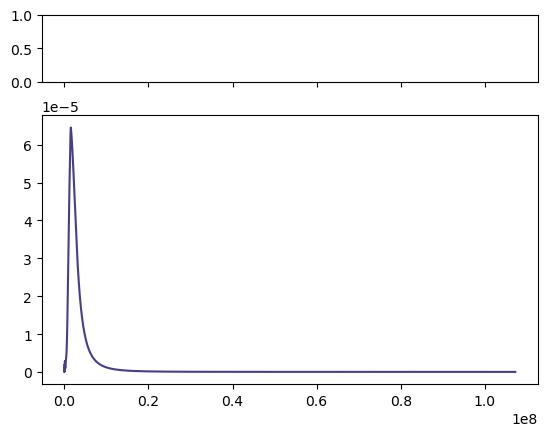

In [23]:
sfig, saxes = pl.subplots(2, 1, gridspec_kw=dict(height_ratios=[1, 4]), sharex=True)
ax = saxes[1]
ax.plot(sps.wavelengths * (1+out_obs["redshift"]), spec, color="darkslateblue", label="posterior sample")